In [7]:
import json
import numpy as np
import networkx as nx
import torch
import torch.utils
from torch.nn import Linear
from torch_scatter import scatter_mean
from torch_geometric.nn import MessagePassing
from torch_geometric.data import DataLoader
from torch_geometric.utils import degree
from torch_geometric.transforms import Compose
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.datasets import TUDataset
from tqdm import trange
from GRASSY.data.ZINCTranch import ZINCDataset
from GRASSY.models.LEGS_module import *
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"


class NetworkXTransform(object):
    def __init__(self, cat=False):
        self.cat = cat

    def __call__(self, data):
        x = data.x
        netx_data = to_networkx(data)
        ecc = self.nx_transform(netx_data)
        nx.set_node_attributes(netx_data, ecc, 'x')
        ret_data = from_networkx(netx_data)
        ret_x = ret_data.x.view(-1, 1).type(torch.float32)
        if x is not None and self.cat:
            x = x.view(-1, 1) if x.dim() == 1 else x
            data.x = torch.cat([x, ret_x], dim=-1)
        else:
            data.x = ret_x
        return data

    def nx_transform(self, networkx_data):
        """ returns a node dictionary with a single attribute
        """
        raise NotImplementedError


class Eccentricity(NetworkXTransform):
    def nx_transform(self, data):
        return nx.eccentricity(data)


class ClusteringCoefficient(NetworkXTransform):
    def nx_transform(self, data):
        return nx.clustering(data)


def get_transform(name):
    if name == "eccentricity":
        transform = Eccentricity()
    elif name == "clustering_coefficient":
        transform = ClusteringCoefficient()
    elif name == "scatter":
        transform = Compose([Eccentricity(), ClusteringCoefficient(cat=True)])
    else:
        raise NotImplementedError("Unknown transform %s" % name)
    return transform


def split_dataset(dataset, splits=(0.8, 0.1, 0.1), seed=0):
    """ Splits data into non-overlapping datasets of given proportions.
    """
    splits = np.array(splits)
    splits = splits / np.sum(splits)
    n = len(dataset)
    torch.manual_seed(seed)
    val_size = int(splits[1] * n)
    test_size = int(splits[2] * n)
    train_size = n - val_size - test_size
    #ds = dataset.shuffle()
    ds = dataset
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    #return ds[:train_size], ds[train_size : train_size + val_size], ds[-test_size:]
    return train_set, val_set, test_set


def accuracy(model, dataset,loss_fn, name):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    total_loss = 0
    for data in loader:
        data = data.to(device)
        pred, sc = model(data)
        total_loss += loss_fn(pred,data.y)
    # correct = float(pred.eq(data.y).sum().item())
    acc = total_loss / len(dataset)
    return acc, pred

class EarlyStopping(object):
    """ Early Stopping pytorch implementation from Stefano Nardo https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d """
    def __init__(self, mode='min', min_delta=0, patience=8, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if metrics != metrics: # slight modification from source, to handle non-tensor metrics. If NAN, return True.
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

def evaluate(model,loss_fn, train_ds, test_ds, val_ds):
    train_acc, train_pred = accuracy(model, train_ds,loss_fn, "Train")
    test_acc, test_pred = accuracy(model, test_ds,loss_fn, "Test")
    val_acc, val_pred = accuracy(model, val_ds,loss_fn, "Test")
    results = {
        "train_acc": train_acc,
        "train_pred": train_pred,
        "test_acc": test_acc,
        "test_pred": test_pred,
        "val_acc": val_acc,
        "val_pred": val_pred,
        "state_dict": model.state_dict(),
    }
    return results

def train_model(out_file):


    TRANCH = "BBAB"
    TRANCH_NAME = 'BBAB'
    dataset = ZINCDataset(f'../final_tranches/{TRANCH}_subset.npy', prop_stat_dict=f'../final_tranches/{TRANCH}_subset_stats.npy', include_ki=False)
    train_ds, val_ds, test_ds = split_dataset(dataset)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)

    
    model = TSNet(
        dataset.num_node_features,
        dataset.num_classes,
        #edge_in_channels=dataset.num_edge_features,
        trainable_laziness=False
    )

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()
    early_stopper = EarlyStopping(mode = 'max',patience=5,percentage=True)

    results_compiled = []
    early_stopper = EarlyStopping(mode = 'min',patience=5,percentage=False)

    model.train()
    for epoch in trange(1, 80 + 1):
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out, sc = model(data)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()
        
        results = evaluate(model, loss_fn, train_ds, test_ds, val_ds)
        print('Epoch:', epoch, results['train_acc'], results['test_acc'])
        results_compiled.append(results['test_acc'])
        #torch.save(results, '%s_%d.%s' % (out_file, epoch, out_end))
        if early_stopper.step(results['val_acc']):
            print("Early stopping criterion met. Ending training.")
            break # if the validation accuracy decreases for eight consecutive epochs, break. 
    model.eval()
    results = evaluate(model, loss_fn, train_ds, test_ds, val_ds)
    print("Results compiled:",results_compiled)
    print('saving scatter model')
    torch.save(model.scatter.state_dict(), str(out_file) + f"{TRANCH_NAME}.npy")


train_model('./final_models/')

ModuleNotFoundError: No module named 'GRASSY'

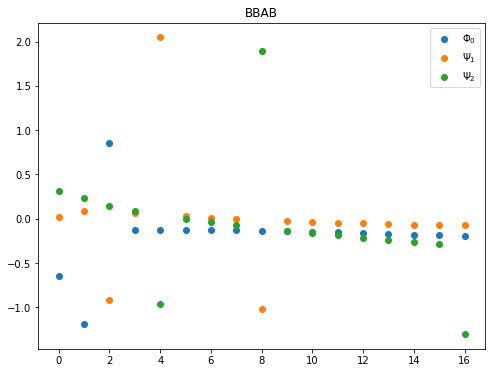

In [4]:
TRANCH_NAME = 'BBAB'
import matplotlib.pyplot as plt



model = Scatter(10, trainable_laziness=False)
model.load_state_dict(torch.load('./final_models/' + f"{TRANCH_NAME}.npy"))
model.eval()
wavelet_constructor = model.wavelet_constructor.detach().numpy()

x = []

for i in range(17):
    x.append(i)

plt.figure(figsize=(8,6))
plt.scatter(x, wavelet_constructor[0], label='$\Phi_0$')
plt.scatter(x, wavelet_constructor[1] - wavelet_constructor[2], label='$\Psi_1$')
plt.scatter(x, wavelet_constructor[2] - wavelet_constructor[3], label='$\Psi_2$')
plt.title(TRANCH_NAME)
plt.legend()
plt.savefig(f'./final_plots/{TRANCH_NAME}.png')